### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Aprendizaje No Supervisado

Integrantes:

- Correa Francisco
- Oviedo Christian

El objetivo de este práctico es encontrar los temas comunes a los documentos, sin tener en cuenta al fuero al que pertenecen.

Realizar Topic Modeling utilizando LDA (Latent Dirichlet Allocation) y (NMF) Non-negative Matrix Factorization sobre el corpus. 

Evaluar velocidad de proceso para saber cuál de los dos es más rápido y cual tiene la agrupación de tópicos más cercana a lo que podrían ser clases válidas para la agrupación de documentos. Es decir, si se corresponden al fuero originario: penal, laboral, familia o menores.

Opcional realizar el proceso utilizando Gensim-Doc2Vec. Generar un input texto y traer los tres documentos con mayor similitud semántica al texto ingresado

Fecha de Entrega: 2 de octubre de 2021

# Búsqueda de tópicos

## Inicialización

Variables de inicialización de la notebook

Para que los experimentos sean repetibles, en todos los modelos que se use random_state, se utilizará el valor indicado en **seed_number**

In [244]:
seed_number=42

## Cargamos el corpus
Cargamos el corpus generado en el práctico 4

In [245]:
import pandas as pd

In [246]:
corpus_file_name = 'cleaned_corpus.csv'

cleaned_corpus_tmp = pd.read_csv(corpus_file_name)

cleaned_corpus = cleaned_corpus_tmp.drop(cleaned_corpus_tmp.columns[0], axis=1)

X = cleaned_corpus['text']  
y = cleaned_corpus['classifier']

In [247]:
cleaned_corpus.head()

text  \
0  dato causa sede ciudad cordoba dependencia juz...   
1  univoco fecha materia revista familia tribunal...   
2  juzgado juventud violencia familiar 8ª cordoba...   
3  auto caratulado a. a. denuncia violencia gener...   
4  juzg adolescencia violencia familiar 4ta cba s...   

                                 id          classifier  
0  4de122c24ab1606c9d67f4ff9e656143  Documentos/MENORES  
1  1f9cdcb2c2596656b540c1271fc2d843  Documentos/MENORES  
2  17dcae14592fc6e87680ccb4251d9395  Documentos/MENORES  
3  4b3ae58648b6267ebb332feec8002588  Documentos/MENORES  
4  1316026beaa1d7e6530bdfe7e54f7b5c  Documentos/MENORES

In [248]:
y

0      Documentos/MENORES
1      Documentos/MENORES
2      Documentos/MENORES
3      Documentos/MENORES
4      Documentos/MENORES
              ...        
238    Documentos/LABORAL
239    Documentos/LABORAL
240    Documentos/LABORAL
241    Documentos/LABORAL
242    Documentos/LABORAL
Name: classifier, Length: 243, dtype: object

Esta funcion hace algo similar a un label enconder. La idea es poder asignar un valor numerico a un label, y que la funcion genere una columna 

In [249]:
def getMapping(data_frame, column, mapping):
    
    return data_frame[column].apply(lambda x : mapping[x])

In [250]:
mapeos = { 'Documentos/MENORES': 0 , 'Documentos/PENAL' : 1 , 'Documentos/FAMILIA': 2, 'Documentos/LABORAL': 3}
getMapping(cleaned_corpus , 'classifier' , mapeos)

0      0
1      0
2      0
3      0
4      0
      ..
238    3
239    3
240    3
241    3
242    3
Name: classifier, Length: 243, dtype: int64

## Vectorizamos usando TFIDF

In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

In [252]:
vectorizer = TfidfVectorizer()

X_train = X

vectorizer.fit(X_train)

TfidfVectorizer()

Creamos un data frame con el resultado de TFIDF para poder consultar los datos de manera más fácil.

In [253]:
def create_idf_data_frame(vectorizer):
    
    df_idf = pd.DataFrame(data = vectorizer.idf_ , columns= ["idf_weight"])
    df_idf['word'] = vectorizer.get_feature_names()

    
    return df_idf


df_idf = create_idf_data_frame(vectorizer)

sorted_df_idf = df_idf.sort_values(by=['idf_weight'])


sorted_df_idf.shape

(17964, 2)

In [254]:
print (f"Cantidad total de terminos {sorted_df_idf.shape[0]}")

Cantidad total de terminos 17964


Buscamos los percentiles 0.025,.05,.075 , 0.1 de los valores IDF

In [255]:
percent_df = sorted_df_idf.quantile([ .025,.05, .075, .1, .125,.15,.175 , .2], axis = 0)
percent_df

idf_weight
0.025    1.964569
0.050    2.471817
0.075    2.833607
0.100    3.164964
0.125    3.406126
0.150    3.663955
0.175    3.932219
0.200    4.099273

Generamos la lista de stop words. Notar que esto lo hacemos de manera empírica. Lo que hacemos es ir variando el tamaño de esta lista y entrenando modelos. Es decir, además de probar diferentes hiper parámetros, también probamos diferentes conjuntos de stop_words a eliminar del corpus. Luego comparamos los resultados obtenidos y buscamos la combinación de hiper parámetros y stop words que mejor resultado arrojen. 

Para poder verificar los valores mostrados en la sección de *Resultado*, se debe ir cambiand el valor de 

limit = percent_df.loc[.1].values[0]

Por ejemplo si queremos que se genere una lista de stop words con el 2.5% de las palabras con IDF más bajo se debe poner 

limit = percent_df.loc[.025].values[0]

In [256]:
#limit = percent_df.loc[.025].values[0]
#limit = percent_df.loc[.05].values[0]
#limit = percent_df.loc[.075].values[0]
limit = percent_df.loc[.1].values[0]
#limit = percent_df.loc[.125].values[0]
#limit = percent_df.loc[.15].values[0]
#limit = percent_df.loc[.175].values[0]




stop_words = df_idf[df_idf['idf_weight'] <= limit ]['word'].values.tolist()
#stop_words = []

In [257]:
print (f"Cantidad de stop words {len(stop_words)}")

Cantidad de stop words 1819


In [258]:
tdf_idf_vectorizer = TfidfVectorizer(stop_words = stop_words )

X_train = cleaned_corpus['text']

X_train_vect = tdf_idf_vectorizer.fit_transform(X_train)

In [259]:
sorted_df_idf = create_idf_data_frame(tdf_idf_vectorizer)

In [260]:
sorted_df_idf

idf_weight          word
0        4.299944            00
1        5.804021          0032
2        5.804021  003553549928
3        5.804021   00412415900
4        5.804021          00hs
...           ...           ...
16140    3.239072          zona
16141    5.110874         zonal
16142    5.804021       zuliani
16143    5.398556        zunino
16144    5.804021        zurito

[16145 rows x 2 columns]

## Vectorizamos usando CountVectorizer

In [261]:
from sklearn.feature_extraction.text import CountVectorizer

In [262]:
c_vectorizer = CountVectorizer(max_df=0.95, min_df=2)

In [263]:
X_train_vect_count = c_vectorizer.fit_transform(X_train)

Funciones auxiliares para armar matris de confución y calcular f1-score

In [264]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt 
import seaborn as sns

# Esta funcion recibe un dictornario de la forma  String: Int y devuelve una lista
# de String donde el orden de los mismos viene dado por el valor Int

def get_columns_from_mapeo(mapeos):
    list_tmp = []

    for value, key in zip(mapeos.values(), mapeos) :
        list_tmp.append((value, key.split("/")[1]))
        
    sorted_list = sorted(list_tmp, key=lambda tup: tup[0])
    
    list_tmp = []
    
    for item in sorted_list:
            list_tmp.append(item[1])
    
    return list_tmp

# Este método genera la matris de confución y calcula el F1-score

def generate_confusion_matrix(true_values, pred_values , mapeos ):
    
    labels = get_columns_from_mapeo (mapeos)
    
    cm =  confusion_matrix(true_values, pred_values  )
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(labels ); ax.yaxis.set_ticklabels(labels , rotation=0);
    f1_result_w = f1_score(true_values, pred_values, average='weighted')
    f1_result_w = round (f1_result_w,3)
    
    
    
    
    ax.text(0,-1, f"f1 Score: {f1_result_w}")

## LDA (Latent Dirichlet Allocation)

In [265]:
from sklearn.decomposition import LatentDirichletAllocation

### Usamos vector IDF

Puesto que ya sabemos que los documentos a clasificar pertenencen a 1 de los 4 fueros (Menores, Familia, Laboral, Penal),utilizamos 4 n_components para LDA

In [266]:
lda = LatentDirichletAllocation(n_components=4, random_state=seed_number )

In [267]:
lda_result_idf = lda.fit_transform(X_train_vect)

In [268]:
len(lda.components_)

4

In [269]:
lda.components_

array([[0.25011633, 0.25003622, 0.25000761, ..., 0.25007023, 0.25017168,
        0.25006591],
       [0.5139993 , 0.29043039, 0.25495404, ..., 0.3750898 , 0.25865162,
        0.25536795],
       [0.37628682, 0.25003347, 0.25000695, ..., 0.25006817, 0.31750957,
        0.43342208],
       [0.25011174, 0.25003627, 0.2500076 , ..., 0.25006893, 0.25045555,
        0.2500659 ]])

Se puede observar que lda esta teniendo problemas para discriminar tópicos. Las palabras que quedan seleccionadas por ada tópico en algunos casos no brinda información suficiente para identificar un fuero y en otros casos, genera dos o más tópicos que tiene casi las mismas palabras.

In [270]:
def show_top_words(model,tdf_idf_vectorizer, top):
    
    for index,topic in enumerate(model.components_):
        print(f"Las {top} palabras más representivas del tópico #{index}")
        print([tdf_idf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-top:]])
        print('\n')  

In [271]:
show_top_words(lda,tdf_idf_vectorizer, 15)

Las 15 palabras más representivas del tópico #0
['remunerar', 'villarreal', 'lujan', 'mapfre', 'josue', 'disfonia', 'sa', 'cerveceria', 'desenlace', 'dimario', 'galeno', 'pedernero', 'piccolo', 'abad', 'transaccion']


Las 15 palabras más representivas del tópico #1
['discapacidad', 'fuego', 'agravante', 'adoptante', 'sexual', 'acogimiento', 'robo', 'guardador', 'suspension', 'abuelo', 'lct', 'despido', 'arma', 'compensacion', 'adoptabilidad']


Las 15 palabras más representivas del tópico #2
['codemandado', 'uniforme', 'sa', '26773', 'mediacion', 'smvm', 'levantamiento', 'bcra', 'ejecutado', 'matricula', 'lrt', 'planilla', 'retroactividad', 'ejecutante', 'reduccion']


Las 15 palabras más representivas del tópico #3
['recepcionada', 'accesibl', 'adaptabl', 'carasso', 'restituyan', 'barrionuevo', 'sisterna', 'personalisimo', '133', 'temporaneidad', 'reclamacion', 'mino', 'ivan', '26844', 'sucesor']




Tomando las palabras más representativas de cada tópico, no nos permiten identificar los fueros sobre los cuales estamos trabajando.

Hacemos algunas pruebas (muy empírico) para ver la matriz de confusión. En todos los casos los resultados no nos buenos.

In [272]:
mapeos = { 'Documentos/MENORES': 2 , 'Documentos/PENAL' : 1 , 'Documentos/FAMILIA': 0, 'Documentos/LABORAL': 3}

In [273]:
get_columns_from_mapeo(mapeos)

['FAMILIA', 'PENAL', 'MENORES', 'LABORAL']

In [274]:
true_values = getMapping(cleaned_corpus , 'classifier' , mapeos)
pred_values = lda_result_idf.argmax(axis=1)

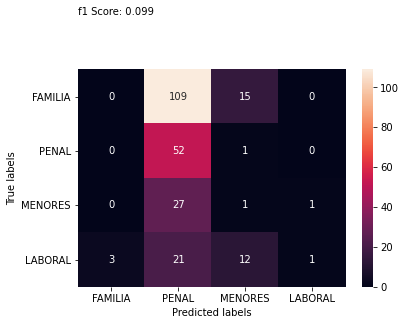

In [275]:
generate_confusion_matrix(true_values, pred_values , mapeos )

### Usamos vector CountVectorizer

In [276]:
lda_count = LatentDirichletAllocation(n_components=4, random_state=seed_number , max_iter=30)

In [277]:
lda_count_result = lda_count.fit_transform(X_train_vect_count)

In [278]:
len(lda_count.components_)

4

In [279]:
lda_count.components_

array([[ 5.95058677,  2.6453459 ,  2.53194056, ..., 49.79519739,
         0.25000004,  1.24889438],
       [ 2.31300726,  1.27684612,  0.25025048, ...,  4.71412176,
         0.25003658,  0.25109589],
       [ 0.27375442,  0.82771211,  1.2887268 , ...,  3.04137646,
         9.24996323,  0.2500003 ],
       [ 4.46265155,  2.25009587,  4.92908216, ...,  2.44930439,
         0.25000016,  1.25000942]])

In [280]:
show_top_words(lda_count,c_vectorizer, 15)

Las 15 palabras más representivas del tópico #0
['señora', 'juicio', 'recurso', 'delito', 'ff', 'año', 'sentencia', 'vta', 'caso', 'sala', 'vocal', 'pena', 'imputado', 'expediente', 'penal']


Las 15 palabras más representivas del tópico #1
['deber', 'caso', 'costa', 'derecho', 'mil', 'hijo', 'señor', 'familia', 'señora', 'agravio', 'cuota', 'apelacion', 'alimentario', 'fecha', 'recurso']


Las 15 palabras más representivas del tópico #2
['civil', 'proteccion', 'fecha', 'interes', 'sr', 'año', 'informe', 'adopcion', 'relacion', 'situacion', 'familiar', 'sra', 'medida', 'familia', 'derecho']


Las 15 palabras más representivas del tópico #3
['laboral', 'angulo', 'blanc', 'eugenio', 'fecha', 'sala', 'recurso', 'rubio', 'voto', 'sentencia', 'expediente', 'luis', 'doctor', 'señor', 'vocal']




Se pueden identificar claramente los 4 fueros:
    
  - 0: Penal
  - 1: Familia
  - 2: Menores
  - 3: Laboral
 
En el caso del tópico 0, no esta definido el fuero. 

 - 0: Familia / Laboral / Menores?

Al estar bien identificados 3 de los 4 fueros, el fuero restante lo tomamos por descarte como fuero Familia



In [281]:
mapeos = { 'Documentos/MENORES': 2 , 'Documentos/PENAL' : 0 , 'Documentos/FAMILIA': 1, 'Documentos/LABORAL': 3}

In [282]:
true_values = getMapping(cleaned_corpus , 'classifier' , mapeos)
pred_values = lda_count_result.argmax(axis=1)

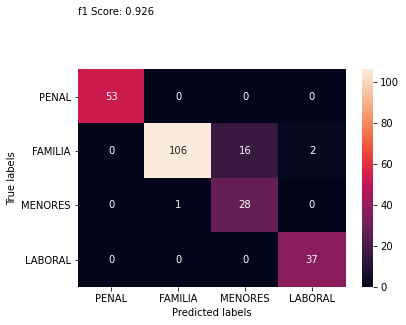

In [283]:
generate_confusion_matrix(true_values, pred_values , mapeos )

## Non-negative matrix

In [284]:
from sklearn.decomposition import NMF

### Usamos vector IDF

Puesto que ya sabemos que los documentos a clasificar pertenencen a 1 de los 4 fueros (Menores, Familia, Laboral, Penal),utilizamos 4 n_components para NMF

In [285]:
nmf_idf = NMF(n_components=4,random_state=seed_number)

In [286]:
nmf_idf_result = nmf_idf.fit_transform(X_train_vect)

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [287]:
show_top_words(nmf_idf,tdf_idf_vectorizer, 15)

Las 15 palabras más representivas del tópico #0
['uniforme', 'fehaciente', 'solventar', 'reclamacion', 'matriculacion', 'conyugal', 'ejecutado', 'incidentista', 'planilla', 'reduccion', 'ejecutante', 'mediacion', 'matricula', 'compensacion', 'retroactividad']


Las 15 palabras más representivas del tópico #1
['mama', '657', 'abuelo', 'innovacion', '607', 'adoptivo', 'apelant', 'hospital', 'pretenso', 'fortalecimiento', 'revinculacion', 'adoptante', 'acogimiento', 'guardador', 'adoptabilidad']


Las 15 palabras más representivas del tópico #2
['suspension', 'reincidencia', '415', 'soto', 'cuello', 'atenuant', 'contrera', 'punitivo', 'sexual', 'discrecional', 'abreviado', 'fuego', 'agravante', 'robo', 'arma']


Las 15 palabras más representivas del tópico #3
['contrato', 'cct', '26773', 'accidente', 'empleadora', 'bcra', 'demandada', 'casar', '25323', 'preaviso', 'antigüedad', 'lrt', 'sa', 'lct', 'despido']




Se pueden identificar claramente 3 fueros:
       
  - 1: Menores
  - 2: Penal
  - 3: Laboral
 
En el caso del tópico 0, no esta definido el fuero. 

 - 0: Familia / Laboral / Menores?

Al estar bien identificados 3 de los 4 fueros, el fuero restante lo tomamos por descarte como fuero Familia


In [288]:
mapeos = { 'Documentos/MENORES': 1 , 'Documentos/PENAL' : 2 , 'Documentos/FAMILIA': 0, 'Documentos/LABORAL': 3}

In [289]:
true_values = getMapping(cleaned_corpus , 'classifier' , mapeos)
pred_values = nmf_idf_result.argmax(axis=1)

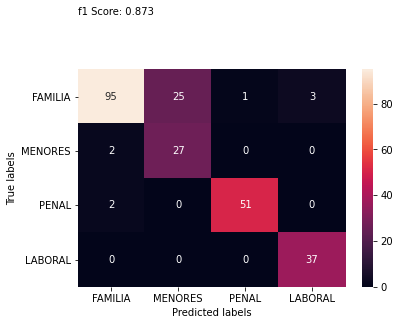

In [290]:
generate_confusion_matrix(true_values, pred_values , mapeos )

Se observa un f1-score aceptable, se notan problemas de clasificación entre los fueros de Familia y Laboral

### Usamos vector CountVectorizer

In [291]:
nmf_count = NMF(n_components=4,random_state=seed_number)

In [292]:
nmf_count_result = nmf_count.fit_transform(X_train_vect_count)

/Users/coviedo/opt/anaconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [293]:
show_top_words(nmf_count,c_vectorizer, 15)

Las 15 palabras más representivas del tópico #0
['daniel', 'año', 'escribano', 'caso', 'ff', 'lascano', 'hecho', 'allende', 'publico', 'pena', 'inmueble', 'vta', 'expediente', 'escritura', 'pace']


Las 15 palabras más representivas del tópico #1
['progenitor', 'apelante', 'familia', 'deber', 'mil', 'costa', 'señora', 'hijo', 'señor', 'apelacion', 'agravio', 'fecha', 'recurso', 'alimentario', 'cuota']


Las 15 palabras más representivas del tópico #2
['relacion', 'sexual', 'sentencia', 'recurso', 'vta', 'caso', 'año', 'sala', 'victima', 'delito', 'pena', 'vocal', 'imputado', 'expediente', 'penal']


Las 15 palabras más representivas del tópico #3
['fecha', 'caso', 'informe', 'proteccion', 'sr', 'año', 'relacion', 'adopcion', 'interes', 'familiar', 'situacion', 'medida', 'sra', 'familia', 'derecho']




Tomando las palabras más representativas de cada tópico, no nos permiten identificar los fueros sobre los cuales estamos trabajando. En el caso anterior, si se veía claramente tres fueros y el restante lo deducíamos por descarte. En este caso no es posible.

Hacemos algunas pruebas (muy empírico) para ver la matriz de confusión. En todos los casos los resultados no nos buenos. Los valores obtenidos en el f1 score son bajos, en todos los casos menores a 0,4

In [294]:
mapeos = { 'Documentos/MENORES': 1 , 'Documentos/PENAL' : 2 , 'Documentos/FAMILIA': 0, 'Documentos/LABORAL': 3}

In [295]:
true_values = getMapping(cleaned_corpus , 'classifier' , mapeos)
pred_values = nmf_count_result.argmax(axis=1)

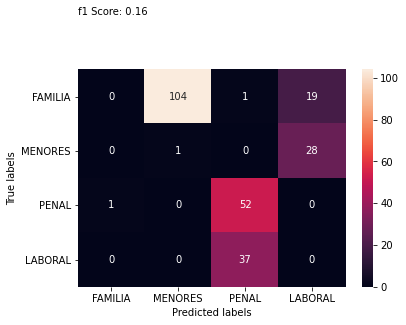

In [296]:
generate_confusion_matrix(true_values, pred_values , mapeos )

# Búsqueda de simlitud entre documentos

In [297]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

Armamos una lista de lista de documentos

In [347]:
def tag_documents(cleaned_corpus_tmp):
    
    X_cleaned_corpus_gensim_list = list(cleaned_corpus_tmp['text'].apply(lambda x: simple_preprocess(x)))
    X_id = cleaned_corpus_tmp['id']
    
    # Este caso se usa cuando la cantidad de documentos es grande y queremos 
    # optmizar el uso de memoria. Con Yield evitamos cargar todo el vector en el stack de la funcion
    #for i, list_of_words in enumerate(X_cleaned_corpus_gensim_list):
    #    yield TaggedDocument(list_of_words, [i])
    
    # Este caso se usa cuando la cantidad de documentos no es significativa. La optimización del uso de memoria no es relevante en este caso
    # tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(X_cleaned_corpus_gensim_list)]

    tagged_data = [TaggedDocument(d, [i]) for i, d in zip(X_id, X_cleaned_corpus_gensim_list )]

    
    
    return tagged_data



In [348]:
cleaned_corpus_tmp[:5]

Unnamed: 0                                               text  \
0           0  dato causa sede ciudad cordoba dependencia juz...   
1           1  univoco fecha materia revista familia tribunal...   
2           2  juzgado juventud violencia familiar 8ª cordoba...   
3           3  auto caratulado a. a. denuncia violencia gener...   
4           4  juzg adolescencia violencia familiar 4ta cba s...   

                                 id          classifier  
0  4de122c24ab1606c9d67f4ff9e656143  Documentos/MENORES  
1  1f9cdcb2c2596656b540c1271fc2d843  Documentos/MENORES  
2  17dcae14592fc6e87680ccb4251d9395  Documentos/MENORES  
3  4b3ae58648b6267ebb332feec8002588  Documentos/MENORES  
4  1316026beaa1d7e6530bdfe7e54f7b5c  Documentos/MENORES

In [349]:
X_cleaned_corpus_gensim_tagged = tag_documents(cleaned_corpus_tmp)

In [350]:
list(X_cleaned_corpus_gensim_tagged)

[TaggedDocument(words=['dato', 'causa', 'sede', 'ciudad', 'cordoba', 'dependencia', 'juzgado', 'adolescencia', 'violencia', 'familiar', 'genero', 'quinto', 'auto', 'denuncia', 'violencia', 'familiar', 'resolucion', 'auto', 'interlocutorio', 'fecha', 'jueza', 'car', 'el', 'olocco', 'otto', 'analisis', 'documental', 'macer', 'veronico', 'ruiu', 'redactora', 'susana', 'macer', 'squizzato', 'tutora', 'sintesis', 'causa', 'jueza', 'violencia', 'rechazar', 'recurso', 'reposicion', 'interpuesto', 'denunciado', 'proveido', 'ordenar', 'conocimiento', 'fiscal', 'instruccion', 'comision', 'ilicito', 'penal', 'consistente', 'incumplimiento', 'medida', 'proteccion', 'dispuesto', 'sumario', 'violencia', 'familiar', 'ordir', 'publico', 'interes', 'social', 'disposicion', 'legal', 'contenido', 'ley', 'violencia', 'familiar', 'orden', 'publico', 'interes', 'social', 'objeto', 'prevencion', 'deteccion', 'temprano', 'atencion', 'erradicacion', 'violencia', 'familiar', 'violencia', 'mujer', 'cuestion', 'g

In [361]:
from sklearn.model_selection import train_test_split

In [362]:
X_cleaned_corpus_gensim_tagged_train, X_cleaned_corpus_gensim_tagged_test =train_test_split(X_cleaned_corpus_gensim_tagged, test_size=0.2, random_state=seed_number, shuffle=True ) 

In [363]:
save_model = True
load_model = False
execute_model = True

In [364]:
if execute_model:
    model = Doc2Vec(X_cleaned_corpus_gensim_tagged_train, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)

In [366]:
if save_model:
    model.save("doc2vec.model")

In [367]:
if load_model or not execute_model:
    model= Doc2Vec.load("doc2vec.model")

In [368]:
model.wv.vocab

{'camara': <gensim.models.keyedvectors.Vocab at 0x1a30943fd0>,
 'familia': <gensim.models.keyedvectors.Vocab at 0x1a309434e0>,
 'cordoba': <gensim.models.keyedvectors.Vocab at 0x1a309432e8>,
 'resolucion': <gensim.models.keyedvectors.Vocab at 0x1a309436a0>,
 'auto': <gensim.models.keyedvectors.Vocab at 0x1a30943860>,
 'homologacion': <gensim.models.keyedvectors.Vocab at 0x1a30943550>,
 'recurso': <gensim.models.keyedvectors.Vocab at 0x1a30943588>,
 'apelacion': <gensim.models.keyedvectors.Vocab at 0x1a309434a8>,
 'cuota': <gensim.models.keyedvectors.Vocab at 0x1a30943438>,
 'alimentario': <gensim.models.keyedvectors.Vocab at 0x1a30943470>,
 'homologado': <gensim.models.keyedvectors.Vocab at 0x1a30943630>,
 'transaccion': <gensim.models.keyedvectors.Vocab at 0x1a30943748>,
 'honorario': <gensim.models.keyedvectors.Vocab at 0x1a309437b8>,
 'abogado': <gensim.models.keyedvectors.Vocab at 0x1a30943828>,
 'remuneracion': <gensim.models.keyedvectors.Vocab at 0x1a30943898>,
 'descripcion': <g

In [455]:
# Este método devuelve una lista de ID para que se usen de filtro en un dataframe

def generateListFromModelResult(result):
    result_list = []
    for item in result:
        result_list.append(item[0])
    return result_list

result_list = generateListFromModelResult(result)

#En base al id de un documento, me devuelve el index
def getIndexById(index , corpus ):
    for i, d in enumerate(corpus):
      if d.tags[0] == index:
        return i
    return -1

getIndexById('6ee6efc9f6c328a30d0cd2c6bb5cd657' ,X_cleaned_corpus_gensim_tagged_train )

def getMostSimilar(id, model, corpus):
    index = getIndexById(id , corpus)
    test_doc = corpus[index].words
    result = model.docvecs.most_similar(positive=[model.infer_vector(test_doc)],topn=5)
    list_result = generateListFromModelResult(result)
    return result

def filterDf(df , values):
    list_values = generateListFromModelResult(values)
    return df.loc[df['id'].isin(list_values)]


In [456]:
test_doc = X_cleaned_corpus_gensim_tagged_train[0].words
test_doc

['camara',
 'familia',
 'cordoba',
 'resolucion',
 'auto',
 'homologacion',
 'recurso',
 'apelacion',
 'cuota',
 'alimentario',
 'homologado',
 'transaccion',
 'honorario',
 'abogado',
 'remuneracion',
 'descripcion',
 'caso',
 'camara',
 'familia',
 'recurso',
 'apelacion',
 'honorario',
 'art',
 'ca',
 'sostener',
 'parte',
 'arribar',
 'cuestion',
 'alimentario',
 'planteado',
 'progenitora',
 'homologar',
 'importar',
 'hipotesis',
 'transaccion',
 'desenlace',
 'cuestion',
 'alimentario',
 'producir',
 'avenimiento',
 'fin',
 'regulatorio',
 'labor',
 'profesional',
 'remunerar',
 'conformidad',
 'prescripto',
 'art',
 'ley',
 'aplicar',
 'escala',
 'art',
 'etapa',
 'transaccion',
 'producir',
 'especie',
 'hipotesis',
 'transaccion',
 'desenlace',
 'cuestion',
 'alimentario',
 'producir',
 'avenimiento',
 'fin',
 'regulatorio',
 'labor',
 'profesional',
 'remunerar',
 'conformidad',
 'prescripto',
 'art',
 'ley',
 'aplicar',
 'escala',
 'art',
 'etapa',
 'transaccion',
 'produci

In [457]:
X_cleaned_corpus_gensim_tagged_train[0].tags

['6ee6efc9f6c328a30d0cd2c6bb5cd657']

In [458]:
result_similar = getMostSimilar('6ee6efc9f6c328a30d0cd2c6bb5cd657', model , X_cleaned_corpus_gensim_tagged_train )
result_similar

[('6ee6efc9f6c328a30d0cd2c6bb5cd657', 0.9985390901565552),
 ('f0f6866a6fbde95b80532081977d1908', 0.9419198632240295),
 ('65ea9da1c9a3b58000665a3836c57a00', 0.9401074051856995),
 ('0cc441d0f0076fed2da4f548d34d7d46', 0.937677264213562),
 ('17aede706df48ccc0ed6c2002fee6e01', 0.9360026717185974)]

In [459]:
filterDf(cleaned_corpus , result_similar)

text  \
115  camara familia 2ª cordoba resolucion auto s. f...   
121  dato causa sede ciudad cordoba dependencia cam...   
131  auto cordobar febrero mil dieciocho ver auto c...   
154  dato causa sede ciudad cordoba dependencia cam...   
169  auto70 t. f190194 cordoba mayo mil dieciseis. ...   

                                   id          classifier  
115  6ee6efc9f6c328a30d0cd2c6bb5cd657  Documentos/FAMILIA  
121  65ea9da1c9a3b58000665a3836c57a00  Documentos/FAMILIA  
131  17aede706df48ccc0ed6c2002fee6e01  Documentos/FAMILIA  
154  f0f6866a6fbde95b80532081977d1908  Documentos/FAMILIA  
169  0cc441d0f0076fed2da4f548d34d7d46  Documentos/FAMILIA

In [445]:
X_cleaned_corpus_gensim_tagged_train[1].tags

['ad322fa71d0190be92a2bce3193ccd9b']

In [460]:
result_similar = getMostSimilar('ad322fa71d0190be92a2bce3193ccd9b', model , X_cleaned_corpus_gensim_tagged_train )
result_similar

[('ad322fa71d0190be92a2bce3193ccd9b', 0.9988579750061035),
 ('d6eb1996b9ae59f9814c4bbb8b19b219', 0.9708690643310547),
 ('a27c00c40e8fc4b357ec24780954f4b1', 0.9602968096733093),
 ('2945229309a265eba82756243a762b10', 0.9552335739135742),
 ('53946aefb4660e6d1441aa0ab626e6b5', 0.9501492977142334)]

In [461]:
filterDf(cleaned_corpus , result_similar)

text  \
207  sala laboral tribunal superior protocolo sente...   
221  sala laboral tribunal superior protocolo sente...   
234  sala laboral tribunal superior protocolo sente...   
235  sala laboral tribunal superior protocolo sente...   
241  sala laboral tribunal superior protocolo sente...   

                                   id          classifier  
207  ad322fa71d0190be92a2bce3193ccd9b  Documentos/LABORAL  
221  2945229309a265eba82756243a762b10  Documentos/LABORAL  
234  d6eb1996b9ae59f9814c4bbb8b19b219  Documentos/LABORAL  
235  53946aefb4660e6d1441aa0ab626e6b5  Documentos/LABORAL  
241  a27c00c40e8fc4b357ec24780954f4b1  Documentos/LABORAL

In [447]:
X_cleaned_corpus_gensim_tagged_test[0].tags

['410acb57c3d56597d97073a162b32507']

In [463]:
result_similar = getMostSimilar('ad322fa71d0190be92a2bce3193ccd9b', model , X_cleaned_corpus_gensim_tagged_test )
result_similar

[('984f40636bd5aaa4d7a292c6395a0ad8', 0.9627338647842407),
 ('01ea4cd49ab4e66e2d3a3130c44ebfc9', 0.9388009905815125),
 ('56bae0d3cd4c969daabc96035eeeca5d', 0.934743344783783),
 ('c4a2f49c56a8b4b4ecc8202ac3464c01', 0.9235641956329346),
 ('a4d9c04801218be64ab514a0b022e26d', 0.9201254844665527)]

In [464]:
filterDf(cleaned_corpus , result_similar)

text  \
23   materia revista familia tribunal juzgado juven...   
27   sentencia trece cordoba veinticinco octubre añ...   
181  dato causa sede ciudad cordoba dependencia cam...   
184  sentencia ciudad cordoba mes marzo mil diecise...   
194  juzgar familia 2a cordoba t. m. f. c. c. b. s/...   

                                   id          classifier  
23   c4a2f49c56a8b4b4ecc8202ac3464c01  Documentos/MENORES  
27   984f40636bd5aaa4d7a292c6395a0ad8  Documentos/MENORES  
181  a4d9c04801218be64ab514a0b022e26d  Documentos/FAMILIA  
184  01ea4cd49ab4e66e2d3a3130c44ebfc9  Documentos/FAMILIA  
194  56bae0d3cd4c969daabc96035eeeca5d  Documentos/FAMILIA